In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import os
import sys
import numpy as np
import pandas as pd
import scipy.signal as sig
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath(r'C:/Users/mmccann/repos/bonhoeffer/prey_capture/'))

import paths
import processing_parameters
import functions_loaders as fl
import functions_data_handling as fdh
import functions_bondjango as bd
from functions_misc import list_lists_to_array, find_nearest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_paths, all_queries = fl.query_search_list()
mice = ['_'.join(os.path.basename(path).split('_')[7:10]) for path in all_paths[0]]
print(all_paths)

data_list = []
# load the data
for path, queries in zip(all_paths, all_queries):
    
    data, _, metadata  = fl.load_preprocessing(path, queries, latents_flag=False)
    data_list.append(data)

data_list = [ds for el in data_list for ds in el]
frame_rate = processing_parameters.wf_frame_rate
kinem_vars = processing_parameters.variable_list_free + processing_parameters.variable_list_fixed


[['Z:\\Prey_capture\\AnalyzedData\\09_27_2023_15_50_10_VTuningWF_MM_230706_b_fullfield_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_27_2023_13_37_57_VTuningWF_MM_230706_a_fullfield_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_27_2023_12_30_21_VTuningWF_MM_230518_b_fullfield_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_15_48_55_VTuningWF_MM_230518_b_repeat_light_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_15_17_29_VTuningWF_MM_230518_b_repeat_light_free0_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_13_37_42_VTuningWF_MM_230706_a_repeat_light_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_13_05_08_VTuningWF_MM_230706_a_repeat_light_free0_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_12_33_38_VTuningWF_MM_230706_b_repeat_light_free1_preproc.hdf5', 'Z:\\Prey_capture\\AnalyzedData\\09_25_2023_12_07_24_VTuningWF_MM_230706_b_repeat_light_free0_preproc.hdf5', 'Z:\\Prey_capture\\Analyze

# Test autocorrelation of kinematic variables

In [27]:
window_size = 10    # seconds

autocorr_dict = {}
for ds in data_list:
    ds.dropna(inplace=True)
    
    if 'wheel_speed' in ds.columns:
        ds['wheel_speed_abs'] = ds['wheel_speed'].abs().copy()

    for kvar in kinem_vars:
        if kvar in ds.columns:

            # Handle exception for x and y position in head fixed data
            if (kvar == 'mouse_x_m') and ('wheel_speed' in ds.columns):
                continue
            elif (kvar == 'mouse_y_m') and ('wheel_speed' in ds.columns):
                continue
            else:
                autocorr_list = []
                x = ds[kvar].to_numpy()

                if window_size == 'all':	
                    xp = x - x.mean()
                    result = sig.correlate(xp, xp, mode='full')
                    result = result[result.size//2:] / np.var(x) / len(xp)

                else:
                    # Parse the signal into chunks
                    chunk_size = x.size//(window_size*frame_rate)
                    if chunk_size < 1:
                        pass
                    else:
                        x = np.array_split(x, chunk_size)
                        for y in x:
                            yp = y - y.mean()
                            result = sig.correlate(yp, yp, mode='full')
                            result = result[result.size//2:] / np.var(y) / len(yp)
                            autocorr_list.append(result)
                        result = list_lists_to_array(autocorr_list)

                autocorr_dict[kvar] = result

C:\Users\mmccann\AppData\Local\Temp\ipykernel_23068\2843944844.py:37: RuntimeWarning: invalid value encountered in divide
  result = result[result.size//2:] / np.var(y) / len(yp)


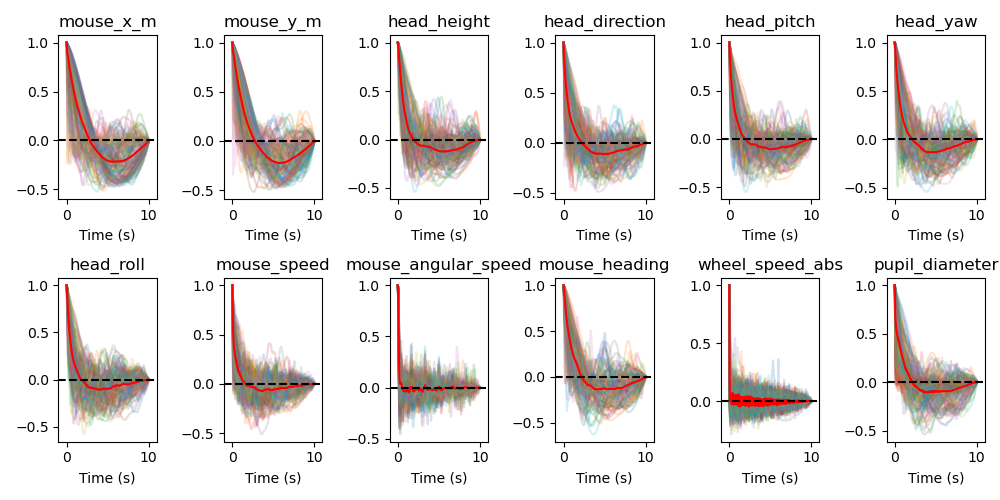

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(10, 5))
mean_autocorr_dict = {}
for ax, key in zip(axes.flatten(), autocorr_dict.keys()):
    autocorr = autocorr_dict[key]
    mean_autocorr = np.mean(autocorr, axis=0)
    mean_autocorr_dict[key] = mean_autocorr
    if window_size != 'all':
        ax.plot(np.arange(0, autocorr.shape[-1])/frame_rate, autocorr.T, alpha=0.2)
        ax.plot(np.arange(0, autocorr.shape[-1])/frame_rate, mean_autocorr, color='r')
        ax.set_xlim(-1, window_size+1)
        ax.hlines(0, -1, window_size+1, color='k', linestyle='--')

    else:
        ax.plot(np.arange(0, autocorr.shape[-1])/frame_rate, autocorr.T)

    ax.set_title(key)
    ax.set_xlabel('Time (s)')

plt.tight_layout()

In [37]:
for key in mean_autocorr_dict.keys():
    autocorr = mean_autocorr_dict[key]
    zero = np.argwhere(np.diff(np.sign(autocorr)))[0][0]
    print(f'Autocorrelation zero crossing for {key} is {zero/frame_rate} seconds')
    print(f'Autocorrelation minimum is {np.nanmin(autocorr)} at {np.nanargmin(autocorr)/frame_rate} seconds\n')

Autocorrelation zero crossing for mouse_x_m is 2.8 seconds
Autocorrelation minimum is -0.21764342223849317 at 5.95 seconds

Autocorrelation zero crossing for mouse_y_m is 2.75 seconds
Autocorrelation minimum is -0.224876542085556 at 5.9 seconds

Autocorrelation zero crossing for head_height is 1.9 seconds
Autocorrelation minimum is -0.12250241958353235 at 5.7 seconds

Autocorrelation zero crossing for head_direction is 2.2 seconds
Autocorrelation minimum is -0.11681073437690295 at 4.9 seconds

Autocorrelation zero crossing for head_pitch is 1.9 seconds
Autocorrelation minimum is -0.10858592106359302 at 5.1 seconds

Autocorrelation zero crossing for head_yaw is 2.1 seconds
Autocorrelation minimum is -0.13276078185762158 at 4.2 seconds

Autocorrelation zero crossing for head_roll is 1.7 seconds
Autocorrelation minimum is -0.10879397861256361 at 4.0 seconds

Autocorrelation zero crossing for mouse_speed is 1.55 seconds
Autocorrelation minimum is -0.07507956001242523 at 3.7 seconds

Autoco